In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from vap.events.events import TurnTakingEvents, EventConfig
from vap.modules.lightning_module import VAPModule
from vap.data.datamodule import VAPDataset, VAPDataModule
from vap.utils.plot import plot_melspectrogram, plot_vad, plot_vap_probs

In [2]:
def plot_output(d, out):
    # Define the ratios for the subplot heights
    height_ratios = [2, 2, 1, 1, 1, 1]

    # Create the figure and the GridSpec instance with the given height ratios
    fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(15, 6), gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.01})

    plot_melspectrogram(d["waveform"], ax=ax[:2])
    # plot vad.
    # VAD is by default longer than the audio (for prediction)
    # See zeros at the end of the waveforms where the VAD is defined but the audio is not.
    x = torch.arange(d["vad"].shape[0]) / dset.frame_hz
    x2 = torch.arange(out["vad"].shape[1]) / dset.frame_hz
    plot_vad(x, d["vad"][:, 0], ax[0], ypad=3, color="b", label="VAD A")
    plot_vad(x, d["vad"][:, 1], ax[1], ypad=3, color="orange", label="VAD A")
    plot_vad(x2, out["vad"][0, :, 0], ax[0], ypad=3, color="w", label="VAD pred")
    plot_vad(x2, out["vad"][0, :, 1], ax[1], ypad=3, color="w", label="VAD pred")
    for i in range(4):
        plot_vap_probs(out['p'][i, 0], ax=ax[2+i])
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].legend()
    ax[1].legend()
    ax[-1].set_xticks(list(range(0, 1+round(x[-1].item())))) #list(range(0, 20)))
    ax[-1].set_xlabel("Time (s)")
    return fig, ax

In [3]:
def plot_event(evnt, ax, frame_hz=50):
    for shift in evnt:
        start = shift[0] / frame_hz
        end = shift[1] / frame_hz
        ch = shift[2]
        for aa in ax:
            aa.axvline(start, color='r')
            aa.axvline(end, color='r', linestyle='dashed')
        print("start: ", start)
        print("end: ", end)
        print("channel: ", ch)

In [4]:
CSV_PATH = "/home/erik/projects/CCConv/VoiceActivityProjection/data/splits/fis_swb/val_sliding.csv"
dset = VAPDataset(CSV_PATH)
print('Dataset: ', len(dset))

Dataset:  16100


In [5]:
df = dset.df

In [6]:
df['audio_path'] = df['audio_path'].apply(lambda x: x.replace('..', '/home/ubuntu'))

In [7]:
dset.df = df

In [8]:
df

,session,audio_path,start,end,vad_list
0,fe_03_05370,/home/erik/projects/data/Fisher/fisher_eng_tr_...,2.960000,22.960000,"[[[0, 0.92], [2.36, 2.99], [6.18, 7.1], [12.42..."
1,fe_03_05370,/home/erik/projects/data/Fisher/fisher_eng_tr_...,19.959999,39.959999,"[[[0, 0.37], [0.4, 2.89], [2.92, 3.77], [3.81,..."
2,fe_03_05370,/home/erik/projects/data/Fisher/fisher_eng_tr_...,36.959999,56.959999,"[[[0, 0.29], [0.7, 1.45], [1.88, 3.84], [5.62,..."
3,fe_03_05370,/home/erik/projects/data/Fisher/fisher_eng_tr_...,53.959999,73.959999,"[[[17.8, 19.47], [19.59, 21.09], [21.23, 21.51..."
4,fe_03_05370,/home/erik/projects/data/Fisher/fisher_eng_tr_...,70.959999,90.959999,"[[[0.8, 2.47], [2.59, 4.09], [4.23, 4.51], [5...."
...,...,...,...,...,...
16095,sw02897,/home/erik/projects/data/switchboard/audio/swb...,277.779999,297.779999,"[[[0, 1.78], [2.81, 3.28], [3.59, 5.61], [6.11..."
16096,sw02897,/home/erik/projects/data/switchboard/audio/swb...,294.779999,314.779999,"[[[0, 3.06], [3.15, 4.44], [11.2, 11.46], [11...."
16097,sw02897,/home/erik/projects/data/switchboard/audio/swb...,311.779999,331.779999,"[[[0, 1.73], [12.39, 12.73], [21.56, 22.0]], [..."
16098,sw02897,/home/erik/projects/data/switchboard/audio/swb...,328.779999,348.779999,"[[[4.56, 5.06], [5.18, 6.91], [7.0, 11.58], [1..."


In [9]:
# CHECKPOINT_PATH = "/home/serhan/Desktop/Original/VoiceActivityProjection/example/checkpoints/checkpoint.ckpt"
CHECKPOINT_PATH = "/home/serhan/Desktop/VoiceActivityProjection/serhan-utils/checkpoints/audio_mixed/epoch=18-step=206738.ckpt"
module = VAPModule.load_from_checkpoint(CHECKPOINT_PATH)
model = module.model

/home/serhan/miniconda3/envs/cleanvap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [10]:
conf = EventConfig(
    metric_time=0.05,
    equal_hold_shift=False,
    sh_pre_cond_time=0.5,
    sh_post_cond_time=0.5,
)
eventer = TurnTakingEvents(conf)

In [11]:
row = torch.randint(0, len(dset), (1,)).item()
row = 3943

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  5.66
end:  5.84
channel:  0
start:  15.86
end:  16.34
channel:  1


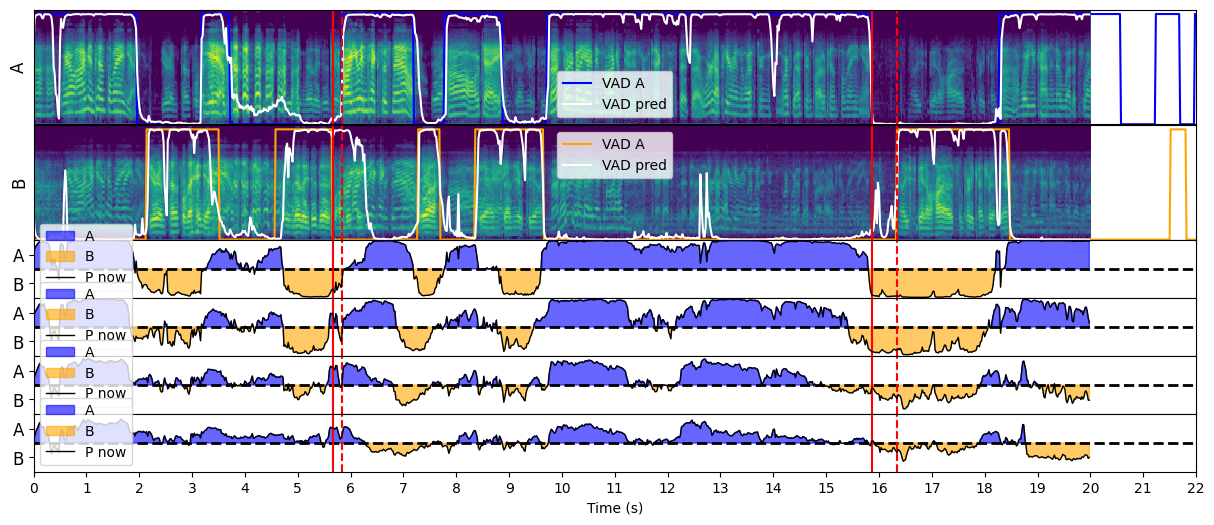

In [12]:
d = dset[row]
out = model.probs(d['waveform'].unsqueeze(0).to('cuda'))
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

In [13]:
d

{'session': 'sw02263',
 'waveform': tensor([[ 0.0040,  0.0056,  0.0060,  ...,  0.0084,  0.0102,  0.0059],
         [-0.0108, -0.0132, -0.0099,  ..., -0.0044, -0.0030, -0.0011]]),
 'vad': tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [1., 0.]]),
 'dataset': ''}

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  5.66
end:  5.84
channel:  0
start:  15.86
end:  16.34
channel:  1


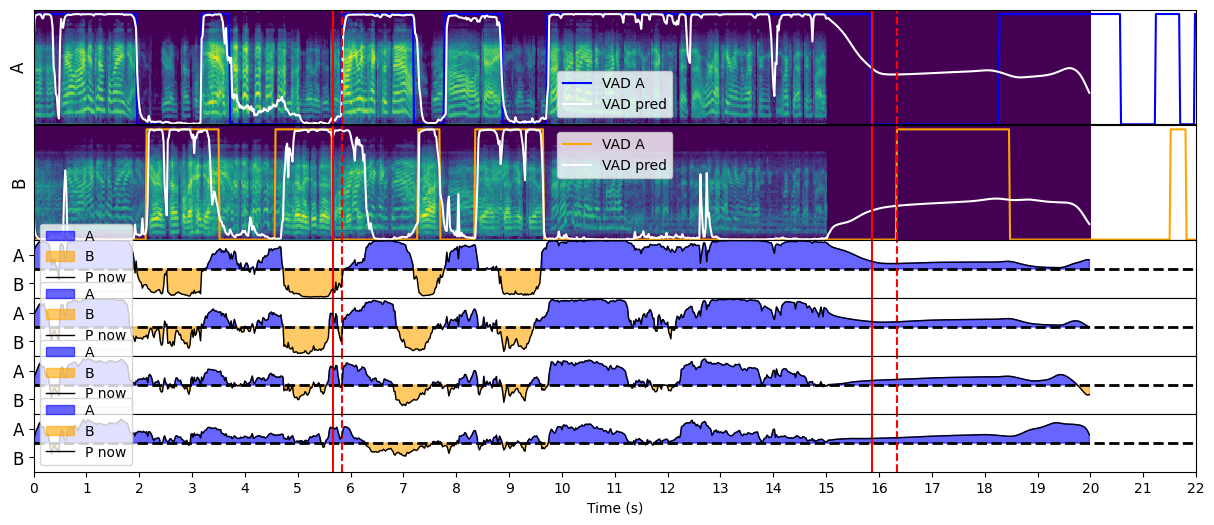

In [14]:
# Mask in the middle
x_masked = d['waveform']
start, end = int(dset.sample_rate * 15), int(dset.sample_rate * 20)
x_masked[:, start:end] = 0
out = model.probs(x_masked.unsqueeze(0).to('cuda'))
d['waveform'] = x_masked
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

start:  5.66
end:  5.84
channel:  0
start:  15.86
end:  16.34
channel:  1


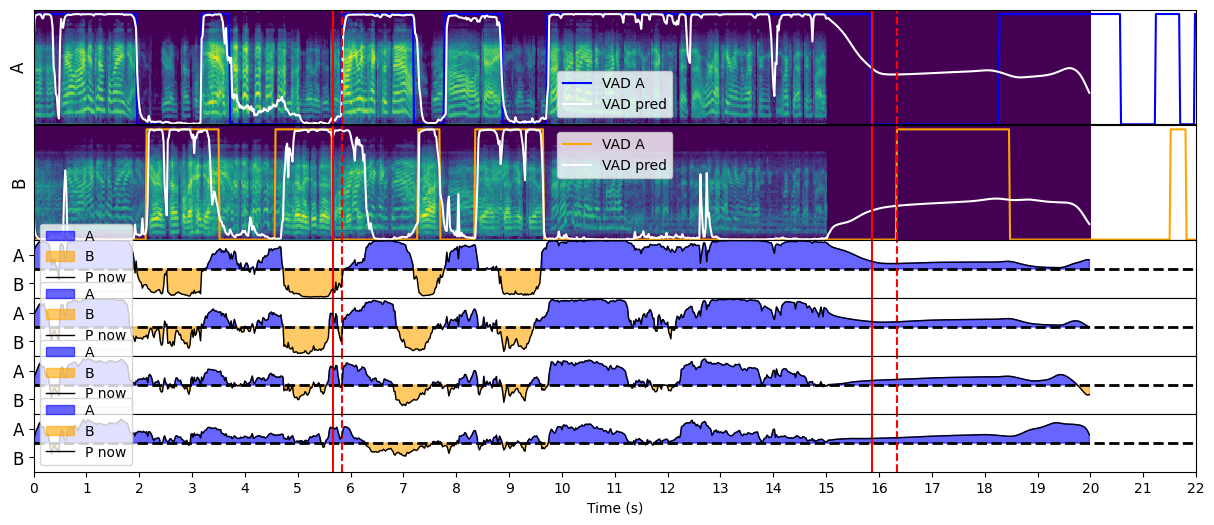

In [15]:
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

In [16]:
plt.show()